In [362]:
import pandas as pd
import _pickle
import numpy as np
from os.path import join
from tqdm import tqdm, tqdm_notebook
import gc
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [176]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [177]:
# Registers the progress bar with pandas
tqdm_notebook().pandas(desc='Progress:')

# 1. Load Data and Create Restaurant Reviews

In [179]:
# Load restaurant and business data
# ---------------------------------

input_folder = join('pickles','3.agg_dfs')

review_data = _pickle.load(open(join(input_folder,'review_data.pkl'),'rb'))
business_data = _pickle.load(open(join(input_folder,'business_data.pkl'),'rb'))

def filter_restaurant_reviews(business_df,reviews_df):
    """
    Takes the restaurant and review dataframes and returns 
    a filtered dataframe of restaurant reviews
    """
    
    print('Creating restaurant boolean')
    restaurant_filter = business_df.categories.progress_apply(lambda x: 'Restaurants' in x)
    restaurant_df = business_df[restaurant_filter]
    restaurant_ids = set(restaurant_df.business_id)
    
    print('Filtering restaurant reviews only')
    restaurant_review_filter = reviews_df['business_id'].progress_apply(lambda x: x in restaurant_ids)
    restaurant_reviews = reviews_df[restaurant_review_filter]
    
    print('Merging restaurant and user review data')
    restaurant_reviews = pd.merge(restaurant_reviews,
                                  restaurant_df,
                                  how='left',
                                  left_on='business_id',
                                  right_on='business_id')
    
    return restaurant_reviews

restaurant_reviews = filter_restaurant_reviews(business_data,review_data)

Creating restaurant boolean

Filtering restaurant reviews only

Merging restaurant and user review data


# 2. Filter for a particular city with many reviews in English-speaking states to reduce dimensionality

In [180]:
# print number of restaurant reviews in English speaking states

english_speaking_states = set(['PA','NC','SC','WI','IL','AZ','CA',
                                   'NV','FL','NM','ON','TX','EDH','MLN',
                                   'HAM','SCB','ELN','FIF','NTH','XGL',
                                   'KHL','MN','AK'])

reviews_per_state = []

for state in english_speaking_states:
    reviews_per_state.append((state, len(restaurant_reviews[restaurant_reviews['state'] == state])))

reviews_per_state.sort(key=lambda x: x[1], reverse=True)

print(reviews_per_state)

[('NV', 662428), ('AZ', 622446), ('NC', 112794), ('PA', 78754), ('WI', 49243), ('EDH', 15189), ('IL', 13054), ('ON', 4814), ('SC', 3532), ('TX', 899), ('MLN', 792), ('NM', 12), ('ELN', 11), ('FIF', 7), ('KHL', 5), ('AK', 3), ('FL', 2), ('NTH', 0), ('SCB', 0), ('XGL', 0), ('CA', 0), ('MN', 0), ('HAM', 0)]


It is clear that Nevada is the state with the most reviews - we will focus on that state

In [181]:
# Filtering restaurants for Las Vegas only

nevada_restaurant_reviews = restaurant_reviews[restaurant_reviews['state'] == 'NV']
nevada_restaurant_reviews['city'].unique()

lasvegas_filter = nevada_restaurant_reviews['city'].progress_apply(lambda x: 'Las Vegas' in x or 'LasVegas' in x)
lasvegas_restaurant_reviews = nevada_restaurant_reviews[lasvegas_filter]

In [182]:
num_lv_reviews = len(lasvegas_restaurant_reviews)
num_lv_restaurants = len(lasvegas_restaurant_reviews.business_id.unique())
num_lv_users = len(lasvegas_restaurant_reviews.user_id.unique())

* There are {{'{:,}'.format(num_lv_reviews)}} reviews of {{'{:,}'.format(num_lv_restaurants)}} restaurants in Las Vegas by {{'{:,}'.format(num_lv_users)}} different users

# 3. Cleaning up data and memory

In [183]:
# Keeping only relevant items

lasvegas_restaurant_reviews = lasvegas_restaurant_reviews[['stars_x',
                                                           'user_id',
                                                           'business_id']]

# 4. Exploring Las Vegas Restaurant Reviews

In [184]:
lasvegas_restaurant_reviews.groupby('business_id').count().describe()

,stars_x,user_id
count,5202.000000,5202.000000
mean,117.185506,117.185506
std,273.051224,273.051224
min,1.000000,1.000000
25%,11.000000,11.000000
50%,33.000000,33.000000
75%,113.000000,113.000000
max,5558.000000,5558.000000


In [185]:
lasvegas_restaurant_reviews.groupby('user_id').count().describe()

,stars_x,business_id
count,216037.000000,216037.000000
mean,2.821734,2.821734
std,7.894279,7.894279
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,2.000000,2.000000
max,887.000000,887.000000


In [131]:
# # Creating unique integers for each restaurant and user for visual comfort
# lasvegas_restaurant_reviews.business_id = lasvegas_restaurant_reviews.business_id.astype('category')
# lasvegas_restaurant_reviews.user_id = lasvegas_restaurant_reviews.user_id.astype('category')

# restaurant_le = LabelEncoder()
# user_le = LabelEncoder()

# restaurant_ident = restaurant_le.fit_transform(lasvegas_restaurant_reviews.business_id)
# user_ident = user_le.fit_transform(lasvegas_restaurant_reviews.user_id)

# # Resetting index for Las Vegas restaurant reviews to ensure new user and business labels match
# lasvegas_restaurant_reviews = lasvegas_restaurant_reviews.reset_index()

# lasvegas_restaurant_reviews['user_ident'] = pd.Series(user_ident)
# lasvegas_restaurant_reviews['restaurant_ident'] = pd.Series(restaurant_ident)

# 5. Filtering for Users with at least 5 reviews  to reduce dimensionality and so that collaborative filtering makes sense 

In [330]:
# Define filter with minimum of 5 reviews
min_review_filter = pd.DataFrame(lasvegas_restaurant_reviews\
                                 .groupby('user_id')\
                                 .count()\
                                 .business_id >= 5)

min_review = min_review_filter\
.rename(columns={'business_id':'user_at_least_{}_reviews'\
                                  .format(min_reviews)})

min_review['user_id'] = min_review.index


# Create filtered reviews dataframe

lv_reviews = pd.merge(lasvegas_restaurant_reviews,
                     min_review,
                     how='left',
                     left_on='user_id',
                     right_on='user_id')

lv_reviews = lv_reviews[lv_reviews['user_at_least_5_reviews']]

n_users = lv_reviews['user_id'].unique().shape[0]
n_restaurants = lv_reviews['business_id'].unique().shape[0]

lv_reviews = lv_reviews.drop('user_at_least_5_reviews', axis=1)
lv_reviews = lv_reviews

In [331]:
lv_reviews = lv_reviews.reset_index()

In [332]:
user_limit = 1000
random_user_idx = np.random.choice(n_users,user_limit,replace=False)

In [333]:
random_user_idx = set(random_user_idx)

In [334]:
user_ident = LabelEncoder().fit_transform(lv_reviews.user_id)

In [335]:
user_ident = pd.DataFrame(user_ident)
user_ident = user_ident.rename(columns={0:'user_ident'})

In [336]:
lv_reviews = pd.concat([lv_reviews,user_ident], axis=1)

In [337]:
lv_reviews_mask = lv_reviews.user_ident.progress_apply(lambda x: x in random_user_idx)

In [338]:
lv_reviews_sample = lv_reviews[lv_reviews_mask]

In [339]:
len(lv_reviews_sample)

11965

In [348]:
n_restaurants = lv_reviews_sample.business_id.unique().shape[0]

In [347]:
n_users = lv_reviews_sample.user_id.unique().shape[0]

In [349]:
lv_reviews = lv_reviews_sample

In [350]:
# Creating unique integers for each restaurant and user for visual comfort
lv_reviews.business_id = lv_reviews.business_id.astype('category')
lv_reviews.user_id = lv_reviews.user_id.astype('category')

restaurant_le = LabelEncoder()
user_le = LabelEncoder()

restaurant_ident = restaurant_le.fit_transform(lv_reviews.business_id)
user_ident = user_le.fit_transform(lv_reviews.user_id)

# Resetting index for Las Vegas restaurant reviews to ensure new user and business labels match
lv_reviews = lv_reviews.reset_index()

lv_reviews['user_ident'] = pd.Series(user_ident)
lv_reviews['restaurant_ident'] = pd.Series(restaurant_ident)

lv_reviews = lv_reviews.drop('index', axis=1)

In [352]:
# Creating training and test set
train_data, test_data = train_test_split(lv_reviews, test_size=0.3)

In [355]:
train_data.head(4)

,level_0,stars_x,user_id,business_id,user_ident,restaurant_ident
10255,275625,4,WaadgVcGvWR4tdIQAtgFdw,L-NzaroskDG7cwW9OJJadw,529,935
7972,216178,5,99J2_TFB68H9y9jKjA_hzA,qth1W742hXtFoNVYvuHBEg,138,2389
97,2498,4,cyqdRUPBvK97jaHYe99cDw,Yq8LiVymGA7vBpGCQuDfRw,632,1577
10612,284495,3,SiWTbZME2p22NyvN-p29Pw,hCmarzJoLFQ8VqAP3aUcjg,460,1975


In [356]:
# Create training and test matrices
R = np.zeros((n_users, n_restaurants))
for line in train_data.itertuples():
    R[line[5]-1,line[6]-1] = line[2]
    
T = np.zeros((n_users, n_restaurants))
for line in test_data.itertuples():
    T[line[5]-1,line[6]-1] = line[2]

In [357]:
# Create index matrix for training data
I = R.copy()
I[I > 0] = 1
I[I == 0] = 0

# Create index matrix for test data
I2 = T.copy()
I2[I2 >0] = 1
I2[I2 == 0] = 0

In [358]:
# Calculate RMSE

def rmse(I,R,Q,P):
    return np.sqrt(np.sum((I * (R - np.dot(P.T,Q)))**2)/len(R[R>0]))

In [359]:
# Initialize ALS hyperparameters

lmbda = 0.1 # Regularization weight
k = 20 # Dimensionality of the latent feature space
m, n = R.shape # number of users and restaurants
n_epochs = 15 # Number of epochs

P = 3 * np.random.rand(k,m) # Latent user feature matrix
Q = 3 * np.random.rand(k,n) # Latent movie feature matrix
Q[0,:] = R[R != 0].mean(axis=0) # Average rating for each movie
E = np.eye(k) # (k x k) - dimensional identity matrix

In [360]:
train_errors = []
test_errors = []

# Repeat until convergence
for epoch in range(n_epochs):
    # Fix Q and estimate P
    for i, Ii in enumerate(I):
        nui = np.count_nonzero(Ii) # Number of items user i has rated
        if (nui == 0): nui = 1 # Be aware of zero counts!
    
        # Least squares solution
        Ai = np.dot(Q, np.dot(np.diag(Ii), Q.T)) + lmbda * nui * E
        Vi = np.dot(Q, np.dot(np.diag(Ii), R[i].T))
        P[:,i] = np.linalg.solve(Ai,Vi)
        
    # Fix P and estimate Q
    for j, Ij in enumerate(I.T):
        nmj = np.count_nonzero(Ij) # Number of users that rated item j
        if (nmj == 0): nmj = 1 # Be aware of zero counts!
        
        # Least squares solution
        Aj = np.dot(P, np.dot(np.diag(Ij), P.T)) + lmbda * nmj * E
        Vj = np.dot(P, np.dot(np.diag(Ij), R[:,j]))
        Q[:,j] = np.linalg.solve(Aj,Vj)
    
    train_rmse = rmse(I,R,Q,P)
    test_rmse = rmse(I2,T,Q,P)
    train_errors.append(train_rmse)
    test_errors.append(test_rmse)
    
    print("[Epoch %d/%d] train error: %f, test error: %f" \
    %(epoch+1, n_epochs, train_rmse, test_rmse))
    
print("Algorithm converged")

# Check performance by plotting train and test errors

plt.plot(range(n_epochs), train_errors, marker='o', label='Training Data');
plt.plot(range(n_epochs), test_errors, marker='v', label='Test Data');
plt.title('ALS-WR Learning Curve')
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE');
plt.legend()
plt.grid()
plt.show()

[Epoch 1/15] train error: 0.931907, test error: 2.529472
[Epoch 2/15] train error: 0.537427, test error: 2.330289
[Epoch 3/15] train error: 0.412784, test error: 2.235607
[Epoch 4/15] train error: 0.347460, test error: 2.173009
[Epoch 5/15] train error: 0.306932, test error: 2.127825
[Epoch 6/15] train error: 0.279436, test error: 2.094226
[Epoch 7/15] train error: 0.259631, test error: 2.068747
[Epoch 8/15] train error: 0.244741, test error: 2.049181
[Epoch 9/15] train error: 0.233181, test error: 2.033944
[Epoch 10/15] train error: 0.223992, test error: 2.021946
[Epoch 11/15] train error: 0.216558, test error: 2.012391
[Epoch 12/15] train error: 0.210461, test error: 2.004701
[Epoch 13/15] train error: 0.205402, test error: 1.998450
[Epoch 14/15] train error: 0.201167, test error: 1.993327
[Epoch 15/15] train error: 0.197590, test error: 1.989095
Algorithm converged


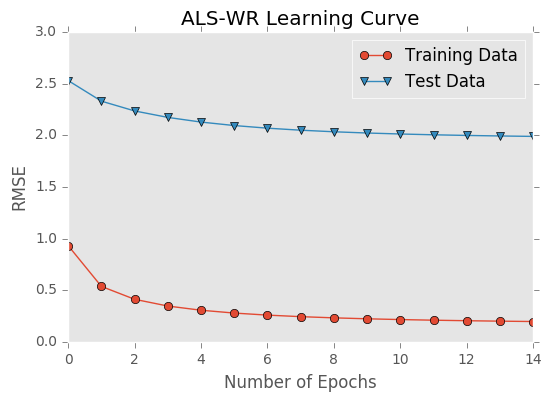

In [363]:
lmbda = 0.1 # Regularization weight
k = 50 # Dimensionality of the latent feature space
m, n = R.shape # number of users and restaurants
n_epochs = 15 # Number of epochs

In [ ]:
lmbda = 10 # Regularization weight
k = 100 # Dimensionality of the latent feature space
m, n = R.shape # number of users and restaurants
n_epochs = 15 # Number of epochs

In [373]:
# Calculate prediction matrix R_hat (low-rank approximation for R)
R_hat = pd.DataFrame(np.dot(P.T,Q))
R = pd.DataFrame(R)

In [368]:
# Compare true ratings of user 6 with predictions
ratings = pd.DataFrame(data=R.loc[5,R.loc[5,:] > 0]).head(n=5)
ratings['Prediction'] = R_hat.loc[5,R.loc[5,:] > 0]
ratings.columns = ['Actual Rating', 'Predicted Rating']

ratings

,Actual Rating,Predicted Rating
52,5.0,4.729594
1547,1.0,0.971685
1641,2.0,2.121603
2068,5.0,4.737970
2699,4.0,3.866673


In [369]:
predictions = R_hat.loc[5,R.loc[5,:] == 0] # Predictions for movies that the user 6 hasn't rated yet
top5 = predictions.sort_values(ascending=False).head(n=5)
recommendations = pd.DataFrame(data=top5)
recommendations.columns = ['Predicted Rating']

recommendations

,Predicted Rating
2427,4.349431
2775,4.227146
264,4.065422
998,4.043889
1540,3.970024
